In [1]:
%%capture
!pip install nb_black worldview_dl tqdm

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
from intake import open_catalog
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from pathlib import Path
import xarray as xr
import numpy as np

import eurec4a

<IPython.core.display.Javascript object>

In [4]:
# cat = eurec4a.get_intake_catalog()
cat = open_catalog(
    "https://raw.githubusercontent.com/leifdenby/eurec4a-intake/twinotter-microphysics/catalog.yml"
)

<IPython.core.display.Javascript object>

# Exploring the Twin-Otter microphysics data

In [5]:
# list the first 10 available files
list(cat.TO.CDP)[:10]

['TO332_1Hz',
 'TO334_1Hz',
 'TO335_1Hz',
 'TO336_1Hz',
 'TO337_1Hz',
 'TO339_1Hz',
 'TO340_1Hz',
 'TO341_1Hz',
 'TO342_1Hz',
 'TO345_1Hz']

<IPython.core.display.Javascript object>

In [6]:
# open up data from a single instrument and flight
# cat.TO.CDP.TO332_1Hz.to_dask()

<IPython.core.display.Javascript object>

In [7]:
microphysics_instruments = ["CDP", "FFSSP", "2DS", "HVPS"]

<IPython.core.display.Javascript object>

In [35]:
# pick a flight for which we know there is data for all instruments
flight_number = 341


def get_available_dataset_for_flight(
    flight_number, instruments=microphysics_instruments
):
    flight_datasets = {}

    for instrument in instruments:
        cat_instrument = cat.TO[instrument]
        flight_identifier = f"TO{flight_number}_1Hz"
        if flight_identifier in cat_instrument:
            ds_inst = cat_instrument[flight_identifier].to_dask()
            ds_inst["instrument"] = instrument
            flight_datasets[instrument] = ds_inst
    return flight_datasets


flight_datasets = get_available_dataset_for_flight(flight_number)
flight_datasets.keys()

dict_keys(['CDP', 'FFSSP', '2DS', 'HVPS'])

<IPython.core.display.Javascript object>

We can't simply merge the datasets because each instrument covers different droplet size ranges and has a different number of size bins. Let's have a look at what these size bins are instead :)

In [9]:
flight_datasets["CDP"]

<xarray.Dataset>
Dimensions:                                      (time: 12904, index: 30)
Coordinates:
  * time                                         (time) datetime64[ns] 2020-0...
Dimensions without coordinates: index
Data variables:
    ambient_particle_diameter                    (index) float32 ...
    measurement_channel_lower_limit              (index) float32 ...
    measurement_channel_upper_limit              (index) float32 ...
    ambient_particle_number_per_channel          (time, index) float32 ...
    number_of_instrument_counts_per_channel      (time, index) float32 ...
    qc_flag_ambient_particle_number_per_channel  (time, index) uint32 ...
    instrument                                   <U3 'CDP'
Attributes: (12/41)
    source:                                Manchester Cloud Droplet Probe
    instrument_manufacturer:               Droplet Measurement Technologies, USA
    instrument_model:                      FFSSP
    instrument_serial_number:              Not available
    instrument_software:                   pads.exe
    instrument_software_version:           Not available
    ...                                    ...
    location_keywords:                     Not applicable
    amf_vocabularies_release:              https://github.com/ncasuk/AMF_CVs/...
    history:                               2020-02-05T00:00:00Z - Data collec...
    comment:                               Data processing was performed to d...
    measurement_technique:                 optical
    Conventions:                           CF-1.6, NCAS-AMF-2.0.0

<IPython.core.display.Javascript object>

(0.1, 32201.35714481636)

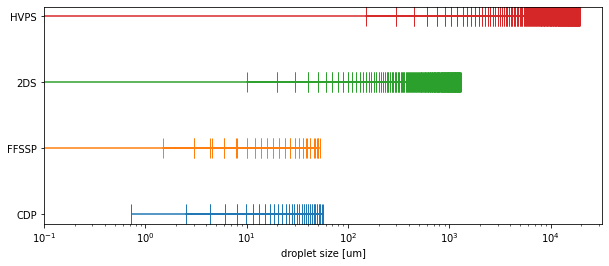

<IPython.core.display.Javascript object>

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.set_xscale("log")

for i, instrument in enumerate(microphysics_instruments):
    if not instrument in flight_datasets:
        pass
    ds_inst = flight_datasets[instrument]

    da_bin_minsize = ds_inst.measurement_channel_lower_limit
    da_bin_maxsize = ds_inst.measurement_channel_upper_limit

    assert da_bin_minsize.units == "um"
    da_bin_center = 0.5 * (da_bin_minsize + da_bin_maxsize)
    da_bin_width = da_bin_maxsize - da_bin_minsize

    ax.errorbar(
        x=da_bin_center,
        y=i * np.ones_like(da_bin_center),
        xerr=da_bin_width,
        label=instrument,
        capsize=10,
    )

ax.set_yticks(range(len(microphysics_instruments)))
ax.set_yticklabels(microphysics_instruments)
ax.set_xlabel(f"droplet size [um]")
ax.set_xlim(0.1, None)

Let's next have a look at plotting using the size bins as the x-coordinate instead of the bin-index

(0.0, 1.2)

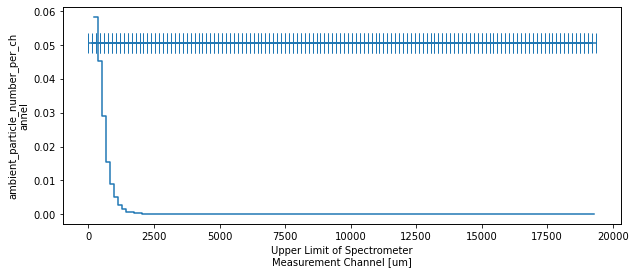

<IPython.core.display.Javascript object>

In [11]:
ds_inst = flight_datasets["HVPS"]
da_bin_minsize = ds_inst.measurement_channel_lower_limit
da_bin_maxsize = ds_inst.measurement_channel_upper_limit

ds_inst_bysize = ds_inst.swap_dims(index="measurement_channel_upper_limit")
da_tot_particles_by_size = ds_inst_bysize.ambient_particle_number_per_channel.sum(
    dim="time"
)

fig, ax = plt.subplots(figsize=(10, 4))

da_tot_particles_by_size.plot.step(ax=ax, where="post")

ax_twinx = ax.twinx()
ax_twinx.errorbar(
    x=da_bin_center,
    y=np.ones_like(da_bin_center),
    xerr=da_bin_width,
    label=instrument,
    capsize=10,
)
ax_twinx.set_yticks([])
ax_twinx.set_ylim(0, 1.2)

dataset is missing `ambient_particle_number_per_channel` for instrument HVPS


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'TO347 10/02/2020 12:49-16:37\ndistribution of droplet-sizes per instrument during flight'}, xlabel='droplet size [um]', ylabel='PDF [1/um]'>)

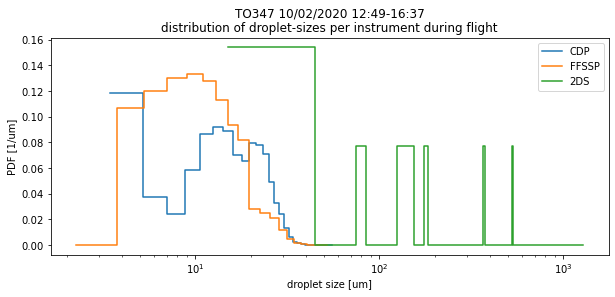

<IPython.core.display.Javascript object>

In [28]:
def plot_size_distributions(flight_datasets, normalized=True):
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.set_xscale("log")

    for i, instrument in enumerate(microphysics_instruments):
        if not instrument in flight_datasets:
            continue
        ds_inst = flight_datasets[instrument]

        if "ambient_particle_number_per_channel" not in ds_inst.data_vars:
            print(
                f"dataset is missing `ambient_particle_number_per_channel` for instrument {instrument}"
            )
            continue

        ds_inst_bysize = ds_inst.swap_dims(index="measurement_channel_upper_limit")
        da_tot_particles_by_size = (
            ds_inst_bysize.ambient_particle_number_per_channel.sum(dim="time")
        )

        if not normalized:
            da_tot_particles_by_size.plot.step(ax=ax, where="post", label=instrument)

        else:
            da_tot_particles_normalized = (
                da_tot_particles_by_size / da_tot_particles_by_size.sum()
            )

            da_tot_particles_normalized.attrs["units"] = "1/um"
            da_tot_particles_normalized.attrs["long_name"] = "PDF"

            da_tot_particles_normalized.plot.step(ax=ax, where="post", label=instrument)

    ax.set_xlabel(f"droplet size [um]")
    ax.legend()
    DATETIME_FORMAT = "%d/%m/%Y %H:%M"

    duration_str = (
        f"{ds_inst.time.min().dt.strftime('%d/%m/%Y').data} "
        f"{ds_inst.time.min().dt.strftime('%H:%M').data}-{ds_inst.time.max().dt.strftime('%H:%M').data}"
    )

    ax.set_title(
        f"TO{flight_number} {duration_str}\ndistribution of droplet-sizes per instrument during flight"
    )

    return fig, ax


plot_size_distributions(flight_datasets)

Now let's process all flights!

# Droplet size as a function of height

In [36]:
# pick a flight for which we know there is data for all instruments
flight_number = 341

flight_datasets = get_available_dataset_for_flight(
    flight_number,
    instruments=microphysics_instruments
    + [
        "MASIN",
    ],
)
flight_datasets.keys()

dict_keys(['CDP', 'FFSSP', '2DS', 'HVPS', 'MASIN'])

<IPython.core.display.Javascript object>

In [37]:
ds_cdp = flight_datasets["CDP"]
ds_masin = flight_datasets["MASIN"]

<IPython.core.display.Javascript object>

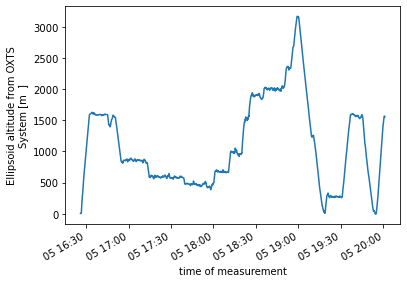

<IPython.core.display.Javascript object>

In [50]:
da_masin_alt_interpolated = ds_masin.interp_like(ds_cdp, method="nearest").ALT_OXTS
da_masin_alt_interpolated.plot()

In [51]:
ds_cdp["alt"] = da_masin_alt_interpolated

<IPython.core.display.Javascript object>

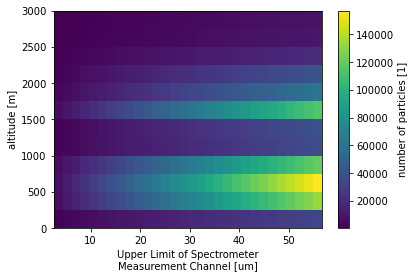

<IPython.core.display.Javascript object>

In [75]:
dz_bin = 250
bins = np.arange(0, ds_cdp.alt.max(), dz_bin)

da_tot_n_droplets_by_height = (
    ds_cdp.swap_dims(index="measurement_channel_upper_limit")
    .groupby_bins(ds_cdp.alt, bins=bins)
    .sum()
).ambient_particle_diameter

da_tot_n_droplets_by_height.alt_bins.attrs["units"] = ds_cdp.alt.units.strip()
da_tot_n_droplets_by_height.alt_bins.attrs["long_name"] = "altitude"
da_tot_n_droplets_by_height.attrs["units"] = "1"
da_tot_n_droplets_by_height.attrs["long_name"] = "number of particles"
da_tot_n_droplets_by_height.plot(y="alt_bins")

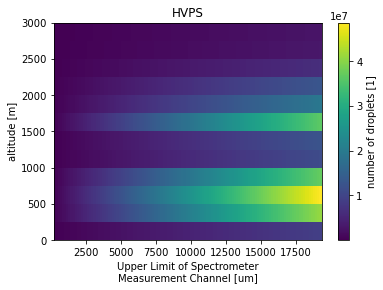

<IPython.core.display.Javascript object>

In [89]:
def plot_size_dist_with_height(flight_datasets, instrument, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    ds_mphys = flight_datasets[instrument]
    ds_masin = flight_datasets["MASIN"]

    da_masin_alt_interpolated = ds_masin.interp_like(
        ds_mphys, method="nearest"
    ).ALT_OXTS
    ds_mphys["alt"] = da_masin_alt_interpolated

    dz_bin = 250
    bins = np.arange(0, ds_mphys.alt.max(), dz_bin)

    da_tot_n_droplets_by_height = (
        ds_mphys.swap_dims(index="measurement_channel_upper_limit")
        .groupby_bins(ds_mphys.alt, bins=bins)
        .sum()
    ).ambient_particle_diameter

    da_tot_n_droplets_by_height.alt_bins.attrs["units"] = ds_mphys.alt.units.strip()
    da_tot_n_droplets_by_height.alt_bins.attrs["long_name"] = "altitude"
    da_tot_n_droplets_by_height.attrs["units"] = "1"
    da_tot_n_droplets_by_height.attrs["long_name"] = "number of droplets"
    da_tot_n_droplets_by_height.plot(y="alt_bins", ax=ax)
    ax.set_title(instrument)


plot_size_dist_with_height(flight_datasets=flight_datasets, instrument="HVPS")

Text(0.5, 1.02, 'TO353')

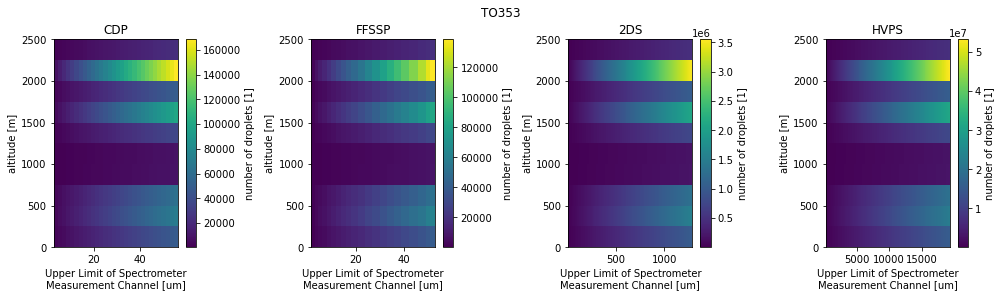

<IPython.core.display.Javascript object>

In [103]:
flight_datasets = get_available_dataset_for_flight(
    342,
    instruments=microphysics_instruments
    + [
        "MASIN",
    ],
)

fig, axes = plt.subplots(ncols=4, figsize=(14, 4))

for ax, instrument in zip(axes, microphysics_instruments):
    plot_size_dist_with_height(
        flight_datasets=flight_datasets, instrument=instrument, ax=ax
    )

fig.tight_layout()
fig.suptitle(f"TO{flight_number}", y=1.02)

# Same instrument across entire campaign

  0%|          | 0/24 [00:00<?, ?it/s]

Text(0.5, 1.0, 'CDP\ndistribution of droplet-sizes per instrument per-flight')

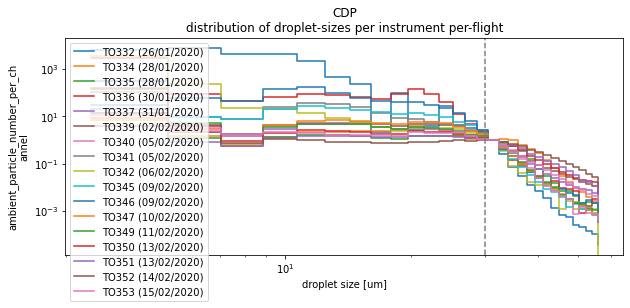

<IPython.core.display.Javascript object>

In [102]:
instrument = "CDP"
normalized = "30um_bin"

fig, ax = plt.subplots(figsize=(10, 4))

ax.set_xscale("log")
ax.set_yscale("log")

for flight_number in tqdm(list(range(330, 354))):
    flight_datasets = get_available_dataset_for_flight(
        flight_number=flight_number, instruments=[instrument]
    )

    if not instrument in flight_datasets:
        continue
    ds_inst = flight_datasets[instrument]

    if "ambient_particle_number_per_channel" not in ds_inst.data_vars:
        print(
            f"dataset is missing `ambient_particle_number_per_channel` for instrument {instrument}"
        )
        continue

    ds_inst_bysize = ds_inst.swap_dims(index="measurement_channel_upper_limit")
    da_tot_particles_by_size = ds_inst_bysize.ambient_particle_number_per_channel.sum(
        dim="time"
    )

    label = f"TO{flight_number} ({ds_inst.time.min().dt.strftime('%d/%m/%Y').data})"

    if not normalized:
        da_tot_particles_by_size.plot.step(ax=ax, where="post", label=label)

    elif normalized == "30um_bin":
        da_tot_particles_normalized = (
            da_tot_particles_by_size
            / da_tot_particles_by_size.sel(
                measurement_channel_upper_limit=30, method="nearest"
            )
        )
        da_tot_particles_normalized.plot.step(ax=ax, where="post", label=label)

    else:
        da_tot_particles_normalized = (
            da_tot_particles_by_size / da_tot_particles_by_size.sum()
        )

        da_tot_particles_normalized.attrs["units"] = "1/um"
        da_tot_particles_normalized.attrs["long_name"] = "PDF"

        da_tot_particles_normalized.plot.step(ax=ax, where="post", label=label)

ax.set_xlabel(f"droplet size [um]")
ax.legend()

ax.axvline(30, color="grey", linestyle="--")

ax.set_title(f"{instrument}\ndistribution of droplet-sizes per instrument per-flight")

# Creating plots for data paper

## size-distrubutions per-flight
Plot with size distribution for all available instruments for each flight

In [30]:
path_plots = Path("plots/")
normalized = False

for flight_number in tqdm(list(range(330, 354))):
    fn_plot = (
        f"TO{flight_number}.droplet_size_dist{normalized and '_normalized' or ''}.png"
    )
    p_plot = path_plots / fn_plot
    if p_plot.exists():
        continue

    flight_datasets = get_available_dataset_for_flight(flight_number=flight_number)
    if len(flight_datasets) == 0:
        print(f"No data found for flight {flight_number}")
        continue

    fig, ax = plot_size_distributions(
        flight_datasets=flight_datasets, normalized=normalized
    )
    p_plot.parent.mkdir(exist_ok=True, parents=True)
    fig.savefig(p_plot)
    plt.close(fig)
    del fig

  0%|          | 0/24 [00:00<?, ?it/s]

No data found for flight 333
No data found for flight 338
No data found for flight 343
dataset is missing `ambient_particle_number_per_channel` for instrument HVPS
No data found for flight 348


<IPython.core.display.Javascript object>